# Steerable Pyramid


This tutorial walks through the basic features of the torch implementation of the Steerable Pyramid. We use the steerable pyramid construction in the frequency domain (such that it provides perfect reconstruction and any number of orientation bands). For more details on steerable pyramids and how they are built, see the pyrtools tutorial at: https://pyrtools.readthedocs.io/en/latest/. 
Here we will specifically focus on the specifics of the torch version and how it may be used in concert with other differentiable torch models. 

In [1]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch import nn
import matplotlib.pyplot as plt

import pyrtools as pt
import plenoptic as po
%matplotlib inline
from plenoptic.simulate import Steerable_Pyramid_Freq
from plenoptic.synthesize import Eigendistortion
from plenoptic.tools.data import to_numpy
dtype = torch.float32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import os
from tqdm import tqdm
DATA_PATH = os.path.abspath('../data')
%load_ext autoreload

%autoreload 2


In [2]:
# We assume that the working directory is 'examples'
%pwd

'/mnt/home/tyerxa/repos/plenoptic/examples'

## Introduction: Steerable Pyramid Wavelets

In this section we will:
1. Visualize the wavelets that produce steerable pyramid coefficients 
2. Visualize the steerable pyramid decomposition for two example images
3. Provide some technical details about this steerable pyramid implementation and how it may differ from others

### 1.1: Visualizing Wavelets

Many modern computer vision algorithms employ convolution: a kernel slides across an image, taking inner products along the way. Thus the output of a convolution at a given location is the similarity between the kernel and the image content at that location, therefore if your kernel has a low-spatial frequency it will function as a low-pass filter. Of course, low-pass filtering has a very simple interpretation in the fourier domain (simply attenuate the high spatial frequencies and leave low spatial frequencies unchanged). This particular scenario belies a more general fact: convolution in the spatial domain is mathematically equivalent to multiplication in the Fourier domain (a result known as the [convolution theorem](https://en.wikipedia.org/wiki/Convolution_theorem)). Though both are equivalent there may be advantages to carrying out the operation in one domain or the other. This implementation of the steerable pyramid operates in the Fourier domain. Because of this we don't have direct access to a set of spatial filters for visualization, however we can generate the equivalent spatial filters by inverting a set of coefficients constructed to contain zero everywhere ~except in the center of a single band~. Below we do this for each band to visualize the filters for a 3 scale 4 orientation steerable pyramid. 

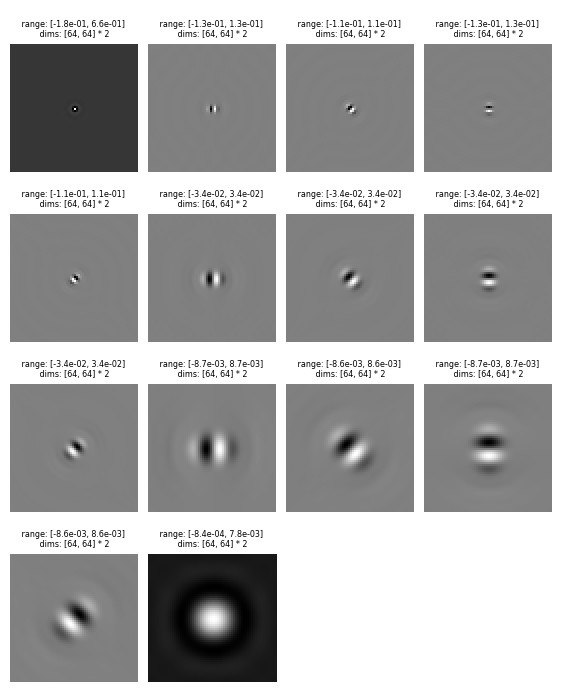

In [3]:
order = 3
imsize = 64
pyr = Steerable_Pyramid_Freq(height=3,image_shape=[imsize,imsize],order=order,is_complex = False,twidth=1, downsample=True)
pyr.to(device)
empty_image = torch.zeros((1,1,imsize,imsize),dtype=dtype).to(device)
pyr_coeffs = pyr.forward(empty_image)

for k,v in pyr.pyr_size.items():
    mid = (v[0]//2, v[1]//2)
    pyr_coeffs[k][0,0,mid[0],mid[1]]=1

reconList = []
for k in pyr_coeffs.keys():
    if isinstance(k, tuple):
        reconList.append(pyr.recon_pyr(pyr_coeffs, k[0], k[1]))
    else:
        reconList.append(pyr.recon_pyr(pyr_coeffs, k))
        
po.imshow(reconList, col_wrap=order+1, vrange='indep1', zoom=2);

We can see that this pyramid is representing a 3 scale 4 orientation decomposition. 

### 1.2 Visualizing Filter Responses (Wavelet Coefficients)
Now let's see what the steerable pyramid representation for images look like. <br>  
Unlike the pyrtools version, because we are using torch we can perform batch computations with the steerable pyramid implementation. Therefore, the input can be a tensor of size (B x C x H x W). In general C = 1, because the pyramid is meant to operate on gray-scale images, but in the current implementation C > 1 will cause the pyramid to run independently on each channel (meaning each of the first two dimesions are treated effectively as batch dimensions). 

torch.Size([2, 1, 256, 256])


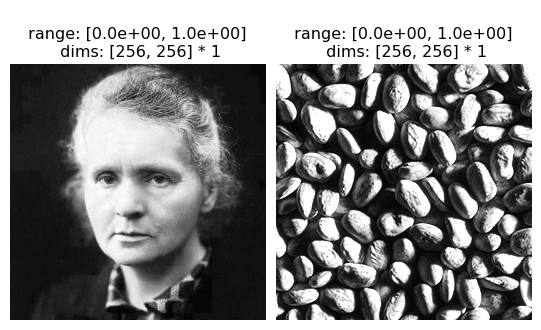

In [4]:
im1 = torch.tensor(plt.imread(os.path.join(DATA_PATH, f'256/curie.pgm')).astype(float), dtype=dtype).to(device) / 255
im2 = torch.tensor(plt.imread(os.path.join(DATA_PATH, f'256/nuts.pgm')).astype(float), dtype=dtype).to(device) / 255
im_batch = torch.stack((im1, im2),0).unsqueeze(1)
print(im_batch.shape)
po.imshow(im_batch)
order = 3
dim_im = 256
pyr = Steerable_Pyramid_Freq(height=4,image_shape=[dim_im,dim_im],order=order,is_complex = True,twidth=1, downsample=False)
pyr.to(device)
pyr_coeffs = pyr(im_batch)

In [5]:
# we can instead use the second dimension as the batch dimension and the results will be the same
im_multi = torch.stack((im1, im2), 0).unsqueeze(0)
print(im_multi.shape)
pyr_coeffs_multi = pyr(im_multi)
print(pyr_coeffs_multi[(0,0)].shape)
pyr_tens, pyr_info = pyr.convert_pyr_to_tensor(pyr_coeffs_multi, split_complex=True)
print(pyr_info)
pyr_coeffs_multi_2 = pyr.convert_tensor_to_pyr(pyr_tens, *pyr_info)
for k in pyr_coeffs_multi.keys():
	print(k)
	print(torch.all(torch.eq(pyr_coeffs_multi[k], pyr_coeffs_multi_2[k])))


torch.Size([1, 2, 256, 256])
torch.Size([1, 2, 256, 256])
(2, True, ('residual_highpass', (0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (1, 3), (2, 0), (2, 1), (2, 2), (2, 3), (3, 0), (3, 1), (3, 2), (3, 3), 'residual_lowpass'))
residual_highpass
tensor(True, device='cuda:0')
(0, 0)
tensor(True, device='cuda:0')
(0, 1)
tensor(True, device='cuda:0')
(0, 2)
tensor(True, device='cuda:0')
(0, 3)
tensor(True, device='cuda:0')
(1, 0)
tensor(True, device='cuda:0')
(1, 1)
tensor(True, device='cuda:0')
(1, 2)
tensor(True, device='cuda:0')
(1, 3)
tensor(True, device='cuda:0')
(2, 0)
tensor(True, device='cuda:0')
(2, 1)
tensor(True, device='cuda:0')
(2, 2)
tensor(True, device='cuda:0')
(2, 3)
tensor(True, device='cuda:0')
(3, 0)
tensor(True, device='cuda:0')
(3, 1)
tensor(True, device='cuda:0')
(3, 2)
tensor(True, device='cuda:0')
(3, 3)
tensor(True, device='cuda:0')
residual_lowpass
tensor(True, device='cuda:0')


By default, the output of the pyramid is stored as a dictionary whose keys are either a string for the 'residual_lowpass' and 'residual_highpass' bands or a tuple of (scale_index, orientation_index). In order to visualize, the pyr_coeffs for each image and channel. Plenoptic provides builtin functionality for visualizing the coefficients. 

odict_keys(['residual_highpass', (0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (1, 3), (2, 0), (2, 1), (2, 2), (2, 3), (3, 0), (3, 1), (3, 2), (3, 3), 'residual_lowpass'])


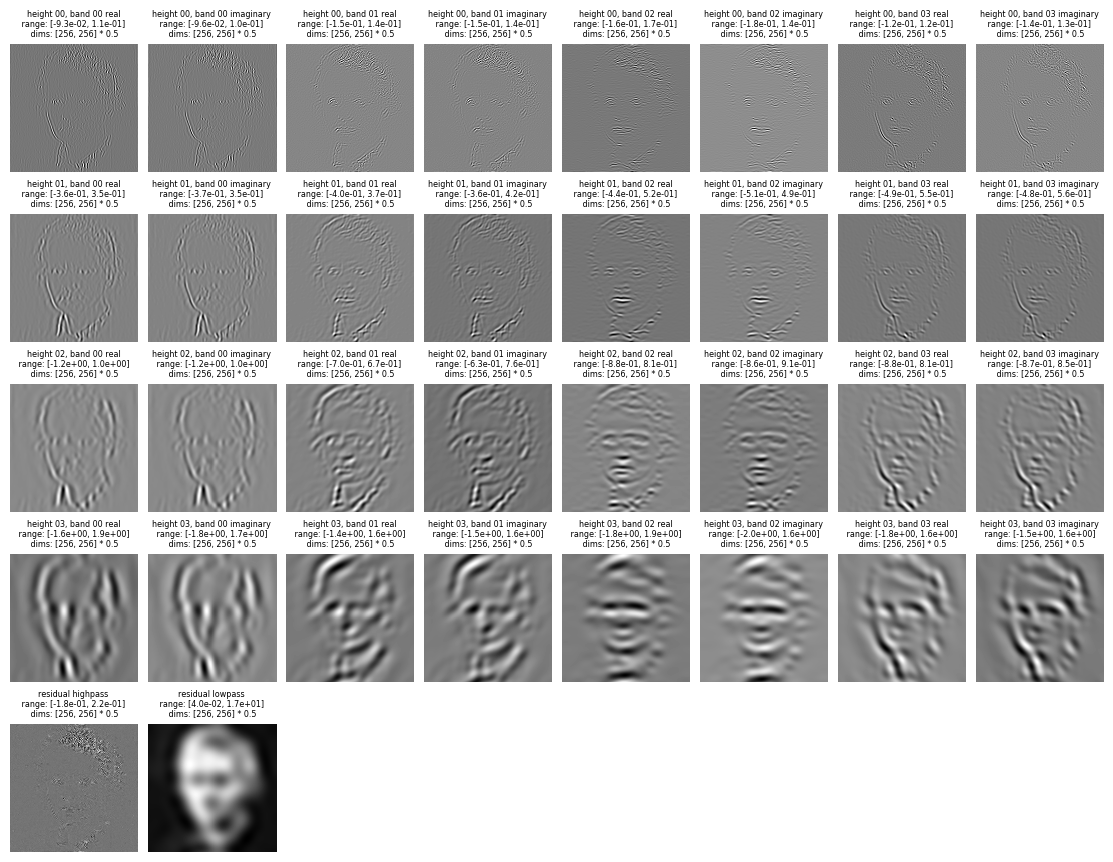

In [6]:
print(pyr_coeffs.keys())
po.pyrshow(pyr_coeffs, zoom=0.5, batch_idx=0);
po.pyrshow(pyr_coeffs, zoom=0.5, batch_idx=1);

For some applications such as coarse-to-fine optimization procedures it may be unneccesary to output a mutliscale representation. We can easily change the output of pyramid by passing a `scales` argument to the forward pass as follows:

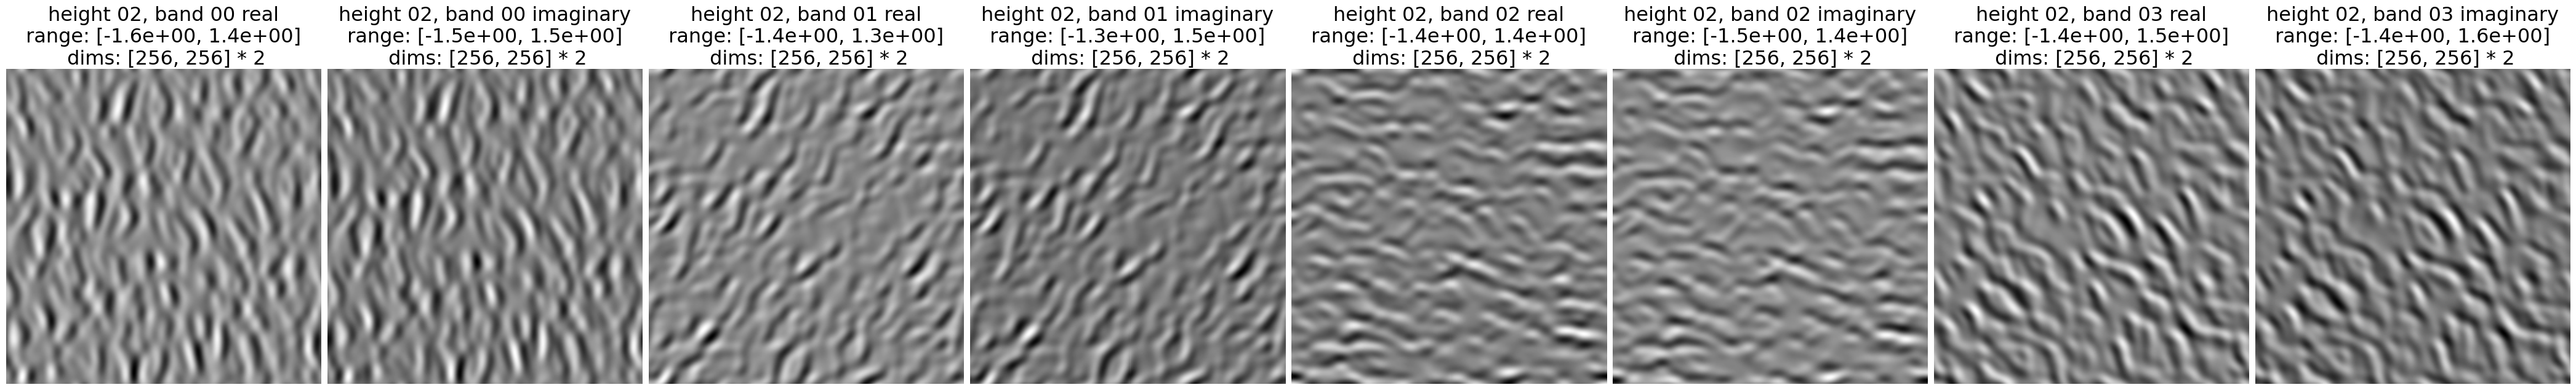

In [7]:
#get the 3rd scale
pyr_coeffs_scale0 = pyr(im_batch, scales=[2])
po.pyrshow(pyr_coeffs_scale0, zoom=2, batch_idx=0);
po.pyrshow(pyr_coeffs_scale0, zoom=2, batch_idx=1);

The above pyramid was the real pyramid but in many applications we might want the full complex pyramid output (complex pyramids have two sets of responses at each scale and orientation corresponding to convolution with a pair of filters with quadrature phase, see [A Parametric Texture Model Based on Joint Statistics
of Complex Wavelet Coefficients for more technical details](http://www.cns.nyu.edu/pub/eero/portilla99-reprint.pdf)). This can be set using the 'is_complex' argument. When this is true, the output of the pyramid will be a dictionary of complex tensors rather than real tensors. 

In [8]:
order = 3
height = 3

pyr_complex = Steerable_Pyramid_Freq(height=height,image_shape=[256,256],order=order,is_complex = True,twidth=1, downsample=True, tight_frame=True)
pyr_complex.to(device)
pyr_coeffs_complex = pyr_complex(im_batch)

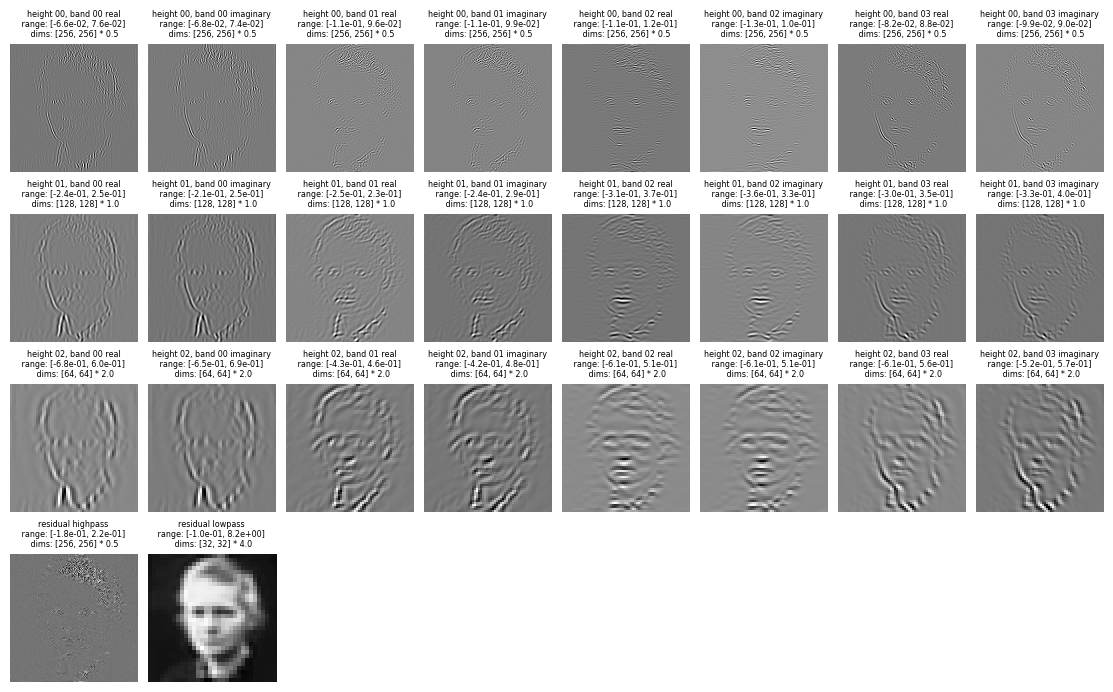

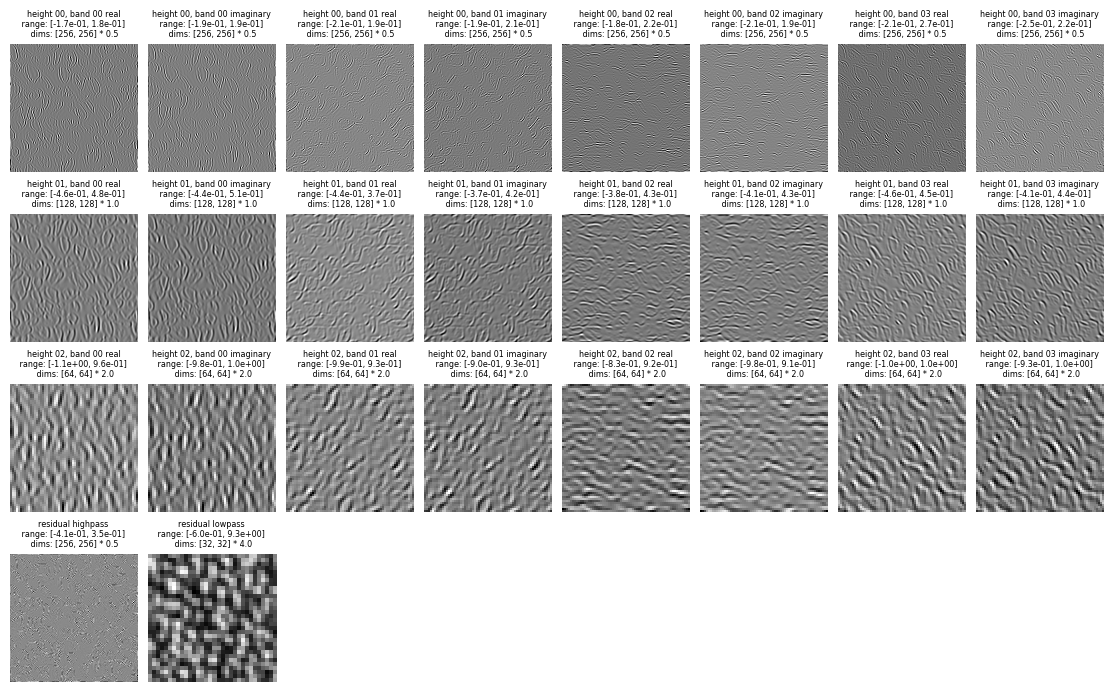

In [9]:
# the same visualization machinery works for complex pyramids; what is shown is the magnitude of the coefficients
po.pyrshow(pyr_coeffs_complex, zoom=0.5, batch_idx=0);
po.pyrshow(pyr_coeffs_complex, zoom=0.5, batch_idx=1);

Now that we have seen the basics of using the pyramid, we will address a few important properties of the torch pyramid that may impact your use-case. 
1. The pyramid as it stands cannot process images with odd-sizes (i.e. 255x255). The reasons for this are being addressed but in the current version, note that if you have odd-sized images you will be forced to convert them to an even size before running through the pyramid. 
2. An important property of the steerable pyramid is that it should respect the generalized parseval theorem (i.e. the energy of the pyramid coefficients should equal the energy of the original image). The matlabpyrtools and pyrtools versions of the SteerablePyramid DO NOT respect this, so in our version, we have provided a fix that normalizes the FFTs such that energy is preserved. This is set by default using the `tight_frame=True` when instantiating the pyramid; however, if you require matching the outputs to the matlabPyrTools or PyrTools versions, please note that you will need to set this argument to False.  

## Putting the "Steer" in Steerable Pyramid
As we have seen, steerable pyramids decompose images into a fixed set of orientation bands (at several spatial scales). However given the responses at this fixed set of orientation bands, the pyramid coefficents for any arbitrary intermediate orientation can be calculated from a linear interpolation of the original bands. This property is known as "steerability."
Below we steer a set of coefficients through a series of angles and visualize how the represeted features rotate.

In [11]:
pyr = Steerable_Pyramid_Freq(height=1,image_shape=[256,256],order=3,is_complex = False,twidth=1, downsample=False) # note that steering is currently only implemeted for real pyramids
pyr.to(device)
coeffs = pyr(im_batch)

N_steer = 64 
M = torch.zeros(1, 1, N_steer, 256, 256)
for i, steering_offset in enumerate(np.linspace(0, 1, N_steer)):
    steer_angle = steering_offset * 2 * np.pi
    steered_coeffs, steering_weights = pyr.steer_coeffs(coeffs, [steer_angle]) # (the steering coefficients are also returned by pyr.steer_coeffs steered_coeffs_ij = oig_coeffs_ij @ steering_weights)
    M[0, 0, i] = steered_coeffs[(0, 4)][1, 0] # we are always looking at the same band, but the steering angle changes

po.tools.convert_anim_to_html(po.animshow(M, framerate=6, repeat=True))

## Example Application: Frontend for Convolutional Neural Network


Until now we have just seen how to use the Steerable Pyramid as a stand-alone fixed feature extractor, but what if we wanted to use it in a larger model, as a front-end for a deep CNN or other model? The steerable pyramid decomposition is qualitatively similar to the computations in primary visual cortex,  \
so it stands to reason that using a steerable pyramid frontend might serve as an inductive bias that encourages subsequent layers to have more biological structure. In the literature it has been demonstrated that using a V1-like front end attached to a CNN trained on classification can lead to improvements in \
adversarial robustness [Dapello et. al, 2020](https://proceedings.neurips.cc/paper/2020/hash/98b17f068d5d9b7668e19fb8ae470841-Abstract.html).

In this section we will:
1. Demonstrate how the plenoptic steerable pyramid can be made compatible with standard deep learning architectures
2. Train CNNs with and without steerable pyramid frontends
3. Use Eigendistortions to analyze how the resulting representations differ.


## Preliminaries
 Most standard model architectures only accept channels with fixed shape, but each scale of the pyramid coefficients has a different shape (because each scale is downsampled by a factor of 2). In order to obtain an output amenable to downstream processing by standard torch nn modules, we have created an argument to the pyramid(`downsample=False`) that does not downsample the frequency masks at each scale and thus maintains output feature maps that all have a fixed size. Once you have done this, you can then convert the dictionary into a tensor of size BxCxHxW so that it can easily be passed to a downstream `nn.Module`. The details of how to do this are provided in the the `convert_pyr_to_tensor` function within the Steerable_Pyramid_Freq class. Let's try this and look at the first image both in the downsampled and not downsampled versions:

In [12]:
height = 3
order = 3
pyr_fixed  = Steerable_Pyramid_Freq(height=height,image_shape=[256,256],order=order,is_complex = True,twidth=1, downsample=False, tight_frame=True)
pyr_fixed.to(device)
pyr_coeffs_fixed, pyr_info = pyr_fixed.convert_pyr_to_tensor(pyr_fixed(im_batch), split_complex=False)
pyr_coeffs_split, _ = pyr_fixed.convert_pyr_to_tensor(pyr_fixed(im_batch), split_complex=True) # we can also split the complex coefficients into real and imaginary parts as separate channels.
print(pyr_coeffs_split.shape)
print(pyr_coeffs_fixed.shape)
#pyr_coeffs_viewed = torch.view_as_real(pyr_coeffs_fixed)
#pyr_coeffs_viewed.shape

torch.Size([2, 26, 256, 256])
torch.Size([2, 14, 256, 256])


We can see that in this complex pyramid with 4 scales and 3 orientations there will be 26 channels: 4 scales x 3 orientations x 2 (for real and imaginary featuremaps) + 2 (for the residual bands). NOTE: you can change what scales/residuals get included in this output tensor again using the `scales` argument to the forward method. 

In order to display the coefficients, we need to convert the tensor coefficients back to a dictionary. We can do this either by directly accessing the dictionary version (through the `pyr_coeffs` attribute in the pyramid object) or by using the internal `convert_tensor_to_pyr` function. We can check that these are equal.

In [14]:
pyr_coeffs_fixed_1 = pyr_fixed(im_batch)
pyr_coeffs_fixed_2 = pyr_fixed.convert_tensor_to_pyr(pyr_coeffs_fixed, *pyr_info)
for k in pyr_coeffs_fixed_1.keys():
    print(torch.allclose(pyr_coeffs_fixed_2[k], pyr_coeffs_fixed_1[k]))

True
True
True
True
True
True
True
True
True
True
True
True
True
True


We can now plot the coefficients for the not downsampled version (`pyr_coeffs_complex`) and the downsampled version `pyr_fixed_dict2` and see how they compare visually. 

tensor(212.8279, device='cuda:0') tensor(212.8279, device='cuda:0')


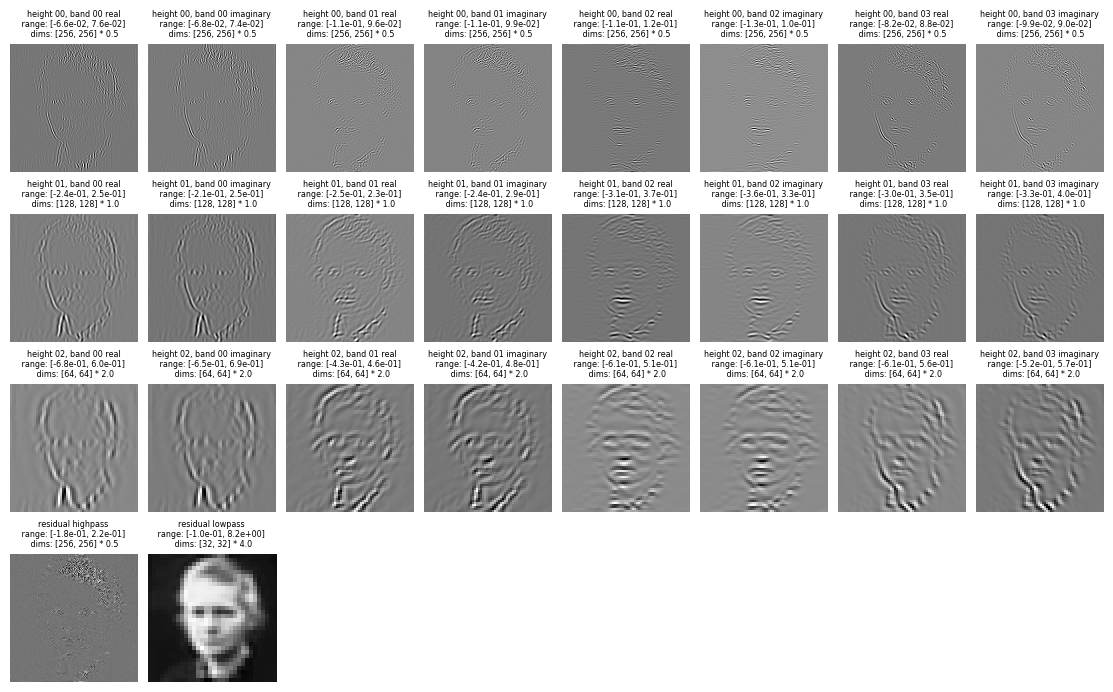

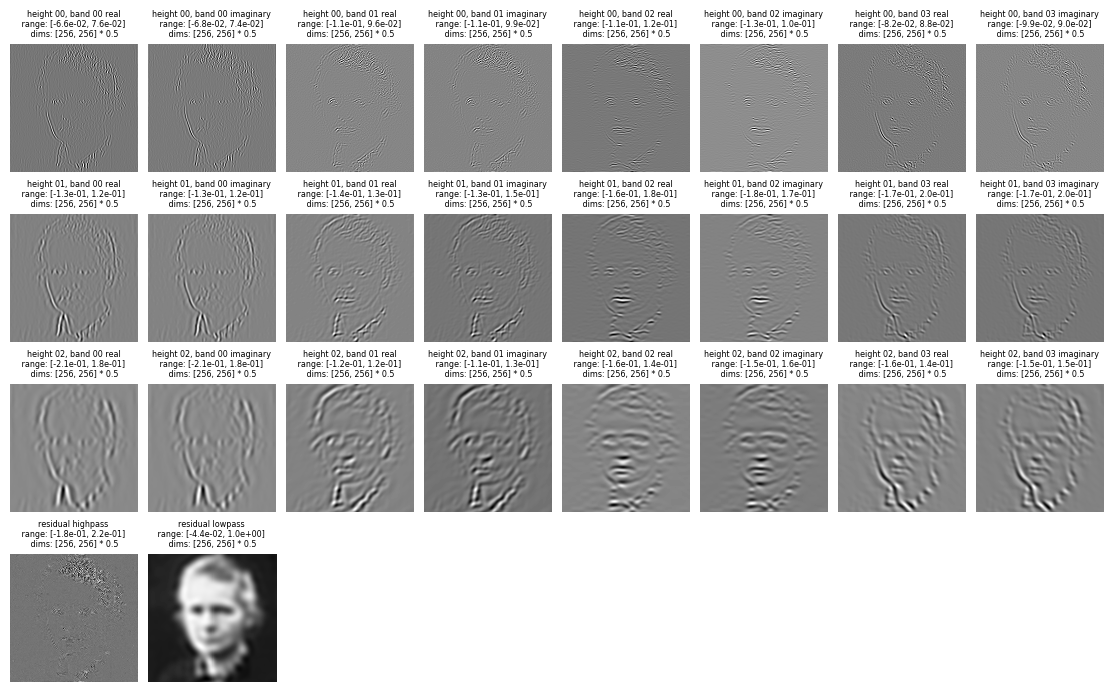

In [15]:
po.pyrshow(pyr_coeffs_complex, zoom=0.5);
po.pyrshow(pyr_coeffs_fixed_1, zoom=0.5);

print(pyr_coeffs_fixed_1[(1,1)].abs().square().sum(), pyr_coeffs_complex[(1,1)].abs().square().sum())

We can see that the not downsampled version maintains the same features as the original pyramid, but with fixed feature maps that have spatial dimensions equal to the original image (256x256). However, the pixel magnitudes in the bands are different due to the fact that we are not downsampling in the frequency domain anymore. This can equivalently be thought of as the inverse operation of blurring and downsampling. Therefore the upsampled versions of each scale are not simply zero interpolated versions of the downsampled versions and thus the pixel values are non-trivially changed.
However, the energy in each band should be preserved between the two pyramids and we can check this by computing the energy in each band for the two pyramids and checking if they are the same. 

In [16]:
pyr_not_downsample  = Steerable_Pyramid_Freq(height=height,image_shape=[256,256],order=order,is_complex = False,twidth=1, downsample=False, tight_frame=False)
pyr_not_downsample.to(device)

pyr_downsample  = Steerable_Pyramid_Freq(height=height,image_shape=[256,256],order=order,is_complex = False,twidth=1, downsample=True, tight_frame=False)
pyr_downsample.to(device)
pyr_coeffs_downsample = pyr_downsample(im_batch.to(device))
pyr_coeffs_not_downsample = pyr_not_downsample(im_batch.to(device))
for i in range(len(pyr_coeffs_downsample.keys())):
    k = list(pyr_coeffs_downsample.keys())[i]
    v1 = to_numpy(pyr_coeffs_downsample[k])
    v2 = to_numpy(pyr_coeffs_not_downsample[k])
    v1 = v1.squeeze()
    v2 = v2.squeeze()
    #check if energies match in each band between downsampled and fixed size pyramid responses
    print(np.allclose(np.sum(np.abs(v1)**2), np.sum(np.abs(v2)**2), rtol=1e-4, atol=1e-4))

def check_parseval(im ,coeff, rtol=1e-4, atol=0):
    '''
    function that checks if the pyramid is parseval, i.e. energy of coeffs is
    the same as the energy in the original image.
    Args:
    input image: image stimulus as torch.Tensor
    coeff: dictionary of torch tensors corresponding to each band
    '''
    total_band_energy = 0
    im_energy = im.abs().square().sum().numpy()
    for k,v in coeff.items():
        band = coeff[k]
        print(band.abs().square().sum().numpy())
        total_band_energy += band.abs().square().sum().numpy()

    np.testing.assert_allclose(total_band_energy, im_energy, rtol=rtol, atol=atol)





True
True
True
True
True
True
True
True
True
True
True
True
True
True


## Model Training
We are now ready to demonstrate how the steerable pyramid can be used as a fixed frontend for further stages of (learnable) processing! Below we train two models for classification on the Fashion MNIST dataset, one with and the other without a steerable pyramid frontend.

In [17]:
# First we define/download the dataset
train_set = torchvision.datasets.FashionMNIST(
    root = DATA_PATH, # downloads FashionMNIST to /path/to/plenoptic/data, change this line if this is not desired
    train = True,
    download = False, # set to true if you do not have FashionMNIST already
    transform = transforms.Compose([
        transforms.ToTensor()                                 
    ])
)

In [18]:
# Define a simple model: SteerPyr --> ConvLayer --> Fully Connected
class PyrConvFull(nn.Module):
    def __init__(self, imshape, order, scales, kernel_size, exclude = [], output_dim = 20, is_complex = True):
        super().__init__()
        
        self.imshape = imshape
        self.order = order
        self.scales = scales
        self.output_dim = output_dim # number of channels in the convolutional block
        self.kernel_size = kernel_size
        self.is_complex = is_complex
        
        self.rect = nn.ReLU()
        self.pyr = Steerable_Pyramid_Freq(height=self.scales,image_shape=self.imshape,
                                          order=self.order,is_complex = self.is_complex,twidth=1, downsample=False)
        
        # num_channels = num_scales * num_orientations (+ 2  residual bands) (* 2 if complex) 
        channels_per = 2 if self.is_complex else 1
        self.pyr_channels = ((self.order + 1) * self.scales + 2) * channels_per 

        self.conv = nn.Conv2d(in_channels=self.pyr_channels, kernel_size=self.kernel_size, 
                              out_channels=self.output_dim, stride = 2)
        self.fc = nn.LazyLinear(10) # determines input size at run time
        
    def forward(self, x):
        out = self.pyr(x)
        out, _ = self.pyr.convert_pyr_to_tensor(out)
        
        # case handling for real v. complex forward passes
        if self.is_complex:
            # split to real and imaginary so nonlinearities make sense
            out_re = self.rect(out.imag)
            out_im = self.rect(out.real)
            
            # concatenate
            out = torch.cat([out_re, out_im], dim=1)
        else:
            out = self.rect(out)
        
            
        out = self.conv(out)
        out = self.rect(out)
        out = out.view(out.shape[0], -1) # reshape for linear layer
        out = self.fc(out)

        return out
    

In [19]:
# Training Pyramid Model
model_pyr = PyrConvFull([28, 28], order=4, scales=2, kernel_size=6, output_dim=20, is_complex=True)
loader = torch.utils.data.DataLoader(train_set, batch_size = 50)
optimizer = torch.optim.Adam(model_pyr.parameters(), lr=1e-3)


epoch = 2
losses = []
fracts_correct = []
for e in range(epoch):
    for batch in tqdm(loader):
        images = batch[0]
        labels = batch[1]
        preds = model_pyr(images)
        loss = F.cross_entropy(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        
        n_correct = preds.argmax(dim=1).eq(labels).sum().item()
        fracts_correct.append(n_correct / 50)
  
fig, axs = plt.subplots(1, 2, figsize=(10, 5))     
axs[0].plot(losses)
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Cross Entropy Loss')
axs[1].plot(fracts_correct)
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('Classification Performance')

/mnt/home/tyerxa/miniconda3/envs/plenoptic/lib/python3.7/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1200/1200 [00:17<00:00, 69.88it/s]


Text(0, 0.5, 'Classification Performance')

To determine the impact of the inclusion of the steerable pyraimid on the learned representation, we need to compare against a baseline that does not use the pyramid as a front end.
So, we create a model with the same architecture (conv-relu-conv-relu-fc), being careful to match the number of channels etc., and train with the same hyperparameters:

In [20]:
# Define a simple alternative: ConvLayer -->  ConvLayer --> Fully Connected
class ConvConvFull(nn.Module):
    def __init__(self, imshape, order, scales, is_complex, kernel_size, output_dim=10):
        super().__init__()
        
        self.imshape = imshape
        self.output_dim = output_dim # output channels for second covolutional layer
        self.kernel_size = kernel_size
        
        self.rect = nn.ReLU()
        
        # use the same number of channels in the first layer as pyramid output 
        channels_per = 2 if is_complex else 1
        self.pyr_channels = ((order + 1) * scales + 2) * channels_per 
        self.conv_1 = nn.Conv2d(in_channels=1,kernel_size=self.kernel_size, 
                              out_channels=self.pyr_channels, stride = 2)

        self.conv_2 = nn.Conv2d(in_channels=self.pyr_channels, kernel_size=self.kernel_size, 
                              out_channels=self.output_dim, stride = 2)
        
        self.fc = nn.LazyLinear(10) # determines input size at runtime
        
    def forward(self, x):
        
        out = self.conv_1(x)
        out = self.rect(out)
        out = self.conv_2(out)
        out = self.rect(out)
        out = out.view(out.shape[0], -1) # reshape for linear layer
        out = self.fc(out) 

        return out

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1200/1200 [00:06<00:00, 190.91it/s]


Text(0, 0.5, 'Classification Performance')

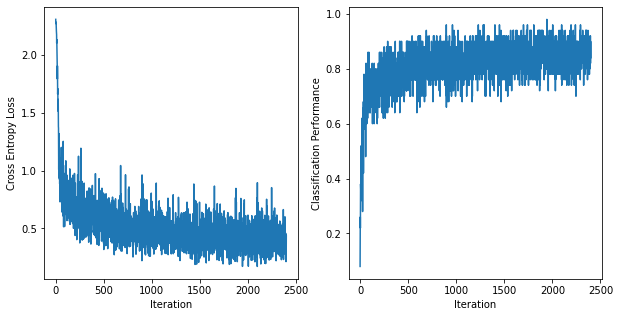

In [21]:
# Training Standard model
model_no_pyr = ConvConvFull([28, 28], order=4, scales=2, kernel_size=6, output_dim=10, is_complex=True)
model_no_pyr = model_no_pyr.to(device)
loader = torch.utils.data.DataLoader(train_set, batch_size = 50)
optimizer = torch.optim.Adam(model_no_pyr.parameters(), lr=1e-3)


epoch = 2
losses = []
fracts_correct = []
for e in range(epoch):
    for batch in tqdm(loader):
        images, labels = batch
        preds = model_no_pyr(images.to(device))
        loss = F.cross_entropy(preds, labels.to(device))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        
        n_correct = preds.argmax(dim=1).eq(labels.to(device)).sum().item()
        fracts_correct.append(n_correct / 50)
        
fig, axs = plt.subplots(1, 2, figsize=(10, 5))     
axs[0].plot(losses)
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Cross Entropy Loss')
axs[1].plot(fracts_correct)
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('Classification Performance')

## Probing the effect of the Steerable Pyramid using Eigendistortions

Eigendistortions provide a way to determine the perturbations a given model is most or least sensitive to. For an introduction to Eigendistortions see here https://github.com/LabForComputationalVision/plenoptic/blob/master/examples/02_Eigendistortions.ipynb or here https://github.com/LabForComputationalVision/plenoptic/blob/master/examples/Demo_Eigendistortion.ipynb. 

Though both models above were trained to relatively similar cross entropy loss and classification performance, one might expect the pyramid model to be sensitive to changes in a more "human-like," way, as the design of the steerable pyramid is roughly inspired by the early primate visual system.

In [22]:
# a sample image
fmnist_im = images[4, :, :]
fmnist_im = fmnist_im.unsqueeze(0)

# initialize distortion synthesizers
eigendist_pyr = Eigendistortion(base_signal=fmnist_im, model=model_pyr.to("cpu"))
eigendist_no_pyr = Eigendistortion(base_signal=fmnist_im, model=model_no_pyr.to("cpu"))

# synthesize distortions
distortions_pyr, eigenvals_pyr, eigenind_pyr = eigendist_pyr.synthesize(k=1, method='power', max_steps=200, tol=1e-4)
distortions_no_pyr, eigenvals_no_pyr, eigenind_no_pyr = eigendist_no_pyr.synthesize(k=1, method='power', max_steps=200, tol=1e-4)


Initializing Eigendistortion -- Input dim: 784 | Output dim: 10

Initializing Eigendistortion -- Input dim: 784 | Output dim: 10


Top k=1 eigendists:   0%|          | 0/200 [00:00<?, ?it/s]

Top k=1 eigendists computed | Tolerance 1.00E-04 reached.


Bottom k=1 eigendists:   0%|          | 0/200 [00:00<?, ?it/s]

Bottom k=1 eigendists computed | Tolerance 1.00E-04 reached.


Top k=1 eigendists:   0%|          | 0/200 [00:00<?, ?it/s]

Top k=1 eigendists computed | Tolerance 1.00E-04 reached.


Bottom k=1 eigendists:   0%|          | 0/200 [00:00<?, ?it/s]

Bottom k=1 eigendists computed | Tolerance 1.00E-04 reached.


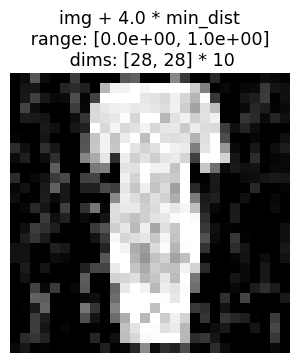

In [23]:
po.imshow(distortions_pyr[[0,-1]].mean(1, keepdim=True), vrange='auto1',
          title=["most-noticeable distortion", "least-noticeable"], zoom=10)

alpha_max, alpha_min = 3., 4.

f_max = eigendist_pyr.plot_distorted_image(eigen_index=0, alpha=alpha_max, title=f'img + {alpha_max} * max_dist',
                                           zoom=10)
f_min = eigendist_pyr.plot_distorted_image(eigen_index=-1, alpha=alpha_min, title=f'img + {alpha_min} * min_dist',
                                           zoom=10)

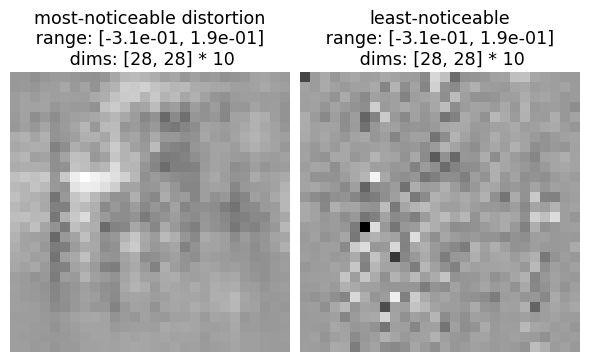

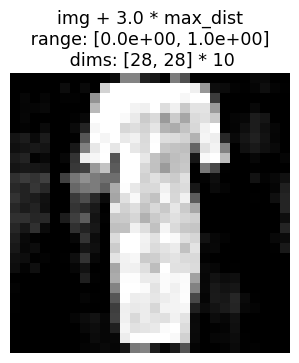

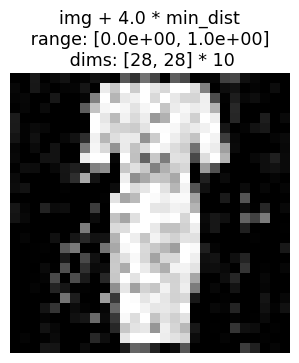

In [24]:
po.imshow(distortions_no_pyr[[0,-1]].mean(1, keepdim=True), vrange='auto1',
          title=["most-noticeable distortion", "least-noticeable"], zoom=10)

alpha_max, alpha_min = 3., 4.
f_max = eigendist_no_pyr.plot_distorted_image(eigen_index=0, alpha=alpha_max, title=f'img + {alpha_max} * max_dist',
                                              zoom=10)
f_min = eigendist_no_pyr.plot_distorted_image(eigen_index=-1, alpha=alpha_min, title=f'img + {alpha_min} * min_dist', 
                                              zoom=10)

Without a psychophysical experiment there's no way to declare one model is more or less human-like in terms of the perturbations it is most/least sensitive too, but you are free to draw your own conclusions! 